# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
  
  Sunday, 31 May 2019, 9:00 - 2:00  Hotel Flora  
  
  
**Convenors**
* [Dr Chelle Gentemann](mailto:gentemann@esr.org)    - Earth and Space Research, USA
* [Dr Marisol Garcia-Reyes](mailto:marisolgr@faralloninstitute.org)  - Farallon Institute, USA 
-------------


# With

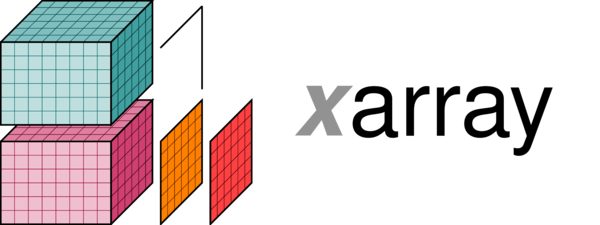

# you can reach

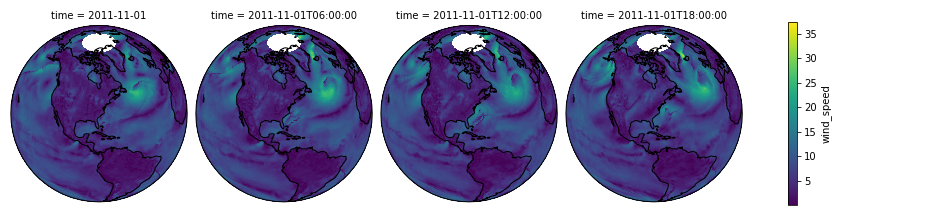

# Structure of this tutorial

1. Opening data
3. Advanced data plotting and exploration
4. Collocating satellite data with a cruise dataset



# 1. Key features of `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot and xarray

In [2]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#for search capabilites import podaacpy
import podaac.podaac as podaac

# then create an instance of the Podaac class
p = podaac.Podaac()

In [3]:
result = p.dataset_search(keyword='ccmp',startTime='2015-01-01',endTime='2015-01-03')
result

TypeError: dataset_search() got an unexpected keyword argument 'startTime'

## Let's open a SST dataset
Below, let's open CMC SSTs using xarray and a PODAAC OpenDAP URL.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.  You can give a local filename or an opendap URL.

Then just print out the file details by just typing the dataset name, ds_ccmp

In [98]:
#url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/2018/255/20180912120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc'
ds_sst = xr.open_dataset(url)
ds_sst

<xarray.Dataset>
Dimensions:           (lat: 1801, lon: 3600, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-12T12:00:00
  * lat               (lat) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * lon               (lon) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      CMC 0.1 deg global sea surface temperature an...
    summary:                    Applies the method of statistical interpolati...
    references:                 Brasnett B. 2008. The impact of satellite ret...
    institution:                CMC
    history:                    Processed through sfc.thin_sst, sfc.sstobs, i...
    comment:                    WARNING Some applications are u

## Plot the SST.  
### Notice xarray adds labels and title to the plot and colorbar.  

Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  Let's change the colorbar label by changing the `long_name` attribute

In [44]:
#print out the attributes for `analysed_sst`
ds_sst.analysed_sst.attrs

OrderedDict([('long_name', 'SST'),
             ('standard_name', 'sea_surface_foundation_temperature'),
             ('units', 'K'),
             ('valid_min', -200),
             ('valid_max', 4000),
             ('source',
              'EUR-L2P-ATS_NR_2P,NAVO-L2P-AVHRR18_G,NAVO-L2P-AVHRRMTA_G,NAVO-L2P-AVHRR19_G,REMSS-WINDSAT,IN_SITU-GTS_BUOYS,IN_SITU-GTS_SHIP,ICE-CMC'),
             ('comment',
              'SST defined at all grid points but no physical meaning is ascribed to values over land')])

In [45]:
#print out the attributes for `analysed_sst`
ds_sst.analysed_sst.attrs['units']='K'
ds_sst.analysed_sst.attrs['long_name']='SST'

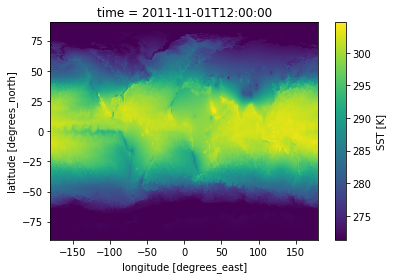

In [46]:
ds_sst.analysed_sst.plot()

## Mask out land values using .where

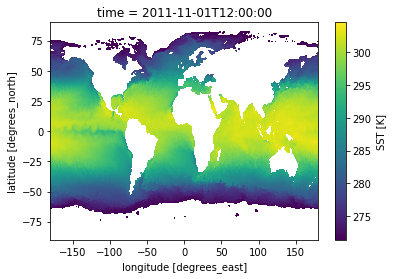

In [48]:
ds_sst_ocn = ds_sst.where(ds_sst.mask==1)
ds_sst_ocn.analysed_sst.plot()

## Subset the data using .sel to the Atlantic region

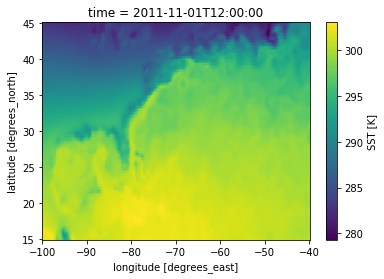

In [85]:
subset = ds_sst.sel(lat=slice(15,45),lon=slice(-100,-40))
subset.analysed_sst.plot()

<xarray.Dataset>
Dimensions:           (lat: 600, lon: 1200, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-12T12:00:00
  * lat               (lat) float32 15.025 15.075 15.125 ... 44.925 44.975
  * lon               (lon) float32 -99.975 -99.925 -99.875 ... -40.075 -40.025
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst:temperature; error:/critical...
    comment:                    WARNING Some applications are unab

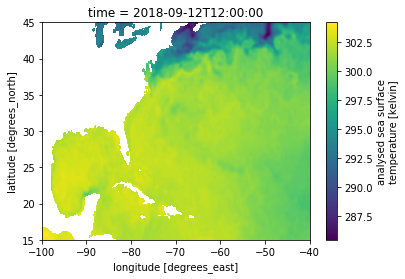

In [130]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst2 = xr.open_dataset(url)
subset2 = ds_sst2.sel(lat=slice(15,45),lon=slice(-100,-40))
print(subset2)
subset2.analysed_sst.plot()

In [95]:
print(subset.lon[0:10].data)
print(subset2.lon[0:10].data)
print(subset.lat[0:10].data)
print(subset2.lat[0:10].data)

[-100.   -99.8  -99.6  -99.4  -99.2  -99.   -98.8  -98.6  -98.4  -98.2]
[-99.975 -99.925 -99.875 -99.825 -99.775 -99.725 -99.675 -99.625 -99.575
 -99.525]
[15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6 16.8]
[15.025 15.075 15.125 15.175 15.225 15.275 15.325 15.375 15.425 15.475]


In [135]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst2 = xr.open_dataset(url)
ds_sst2 = ds_sst2.drop({'analysis_error','sea_ice_fraction'}).isel(time=0).sel(lat=slice(15,45),lon=slice(-100,-40))
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/2018/255/20180912120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc'
ds_sst = xr.open_dataset(url)
ds_sst = ds_sst.drop({'analysis_error','sea_ice_fraction'}).isel(time=0).sel(lat=slice(15,45),lon=slice(-100,-40))

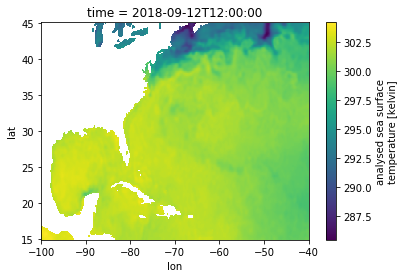

In [138]:
ds_sst2a = ds_sst2.interp_like(ds_sst)
ds_sst2a.analysed_sst.plot()

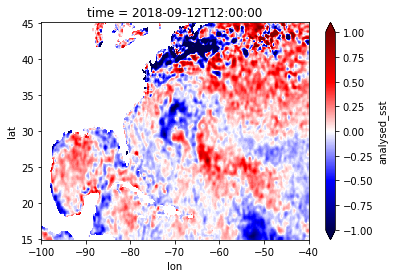

In [141]:
(ds_sst2a.analysed_sst-ds_sst.analysed_sst).plot(vmin=-1,vmax=1,cmap='seismic')

## If you look at the time values you can see that the dataset is at :00, :06, :12, :18

* If you look at the lon values you can see that this dataset is 0-360 rather than -180-180, 

*  let's change the longitude coordinates using [.coords](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coords.html) and then [.sortby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sortby.html) |

* this bit of code can be really useful if you open lots of gridded datasets.  I keep it on a post-it note on my desktop.

## To get from 0-360 to -180-180
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180  
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## To get from -180-180 to 0-360
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp['lon'], 360)
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## Okay, try going from 0-360 to -180-180 below and then print out the dataset

In [8]:
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)

## Now look at your dataset, both are -180 to 180!


In [9]:
#Just a note, that to print out data you should us print(ds_ccmp.lon) to be 'correct'
ds_ccmp.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

## Calculate wind speed and direction from the vectors

In [10]:
ds_ccmp['wind_speed'] = np.sqrt(ds_ccmp.uwnd**2 + ds_ccmp.vwnd**2)
ds_ccmp['wind_dir'] = np.arctan2(ds_ccmp.vwnd,ds_ccmp.uwnd)/np.pi*180


# 5. Graphics 

``xarray`` plotting functions rely on matplotlib internally, but they make use of all available metadata to make the plotting operations more intuitive and interpretable.  Plotting examples are given [here](http://xarray.pydata.org/en/stable/plotting.html)

# Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2,figsize=[12,4])`

* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument

* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next

* Change the number of bins using an argument in hist eg.  `bins=20`

* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`


(array([5.02889571e-02, 8.74879889e-02, 9.01329536e-02, 8.66946477e-02,
        8.15865353e-02, 5.93494655e-02, 3.47647162e-02, 2.14095703e-02,
        1.22863780e-02, 5.41711258e-03, 2.35416713e-03, 1.25492499e-03,
        7.14544353e-04, 5.08593539e-04, 2.24727149e-04, 1.43263703e-04,
        9.22565025e-05, 5.51469157e-05, 3.03086575e-05, 7.54018722e-06]),
 array([3.0519441e-03, 1.8728966e+00, 3.7427411e+00, 5.6125860e+00,
        7.4824305e+00, 9.3522749e+00, 1.1222119e+01, 1.3091965e+01,
        1.4961809e+01, 1.6831654e+01, 1.8701498e+01, 2.0571342e+01,
        2.2441187e+01, 2.4311031e+01, 2.6180876e+01, 2.8050722e+01,
        2.9920567e+01, 3.1790411e+01, 3.3660255e+01, 3.5530098e+01,
        3.7399944e+01], dtype=float32),
 <a list of 1 Patch objects>)

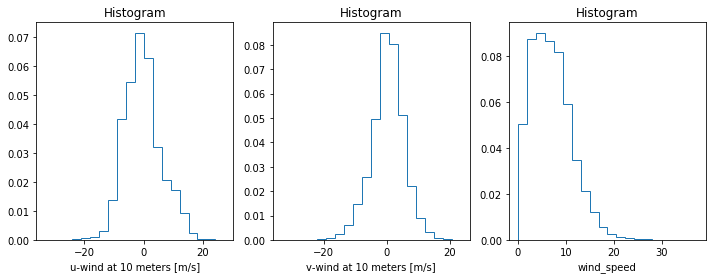

In [11]:
fig, axes = plt.subplots(ncols=3,figsize=[12,4])
ds_ccmp.uwnd.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
ds_ccmp.vwnd.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')
ds_ccmp.wind_speed.plot.hist(bins=20,ax=axes[2],density = True,histtype='step')

### Notice the x-axis label in the right most figure.  

We probably want something more descriptive.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  We created the variable `wind_speed` but didn't add any metadata.  So below, let's print out the metadata attributes for uwnd then add a dictonary of attributes to `wind_speed` so that the plot will be labelled correction 

In [12]:
ds_ccmp.uwnd.attrs

OrderedDict([('long_name', 'u-wind at 10 meters'),
             ('units', 'm/s'),
             ('valid_range', array([-100.,  100.], dtype=float32)),
             ('actual_range', array([-33.10769 ,  27.189566], dtype=float32))])

In [13]:
ds_ccmp.wind_speed.attrs={'long_name':'wind speed at 10 meters','units':'m/s'}

(array([5.02889571e-02, 8.74879889e-02, 9.01329536e-02, 8.66946477e-02,
        8.15865353e-02, 5.93494655e-02, 3.47647162e-02, 2.14095703e-02,
        1.22863780e-02, 5.41711258e-03, 2.35416713e-03, 1.25492499e-03,
        7.14544353e-04, 5.08593539e-04, 2.24727149e-04, 1.43263703e-04,
        9.22565025e-05, 5.51469157e-05, 3.03086575e-05, 7.54018722e-06]),
 array([3.0519441e-03, 1.8728966e+00, 3.7427411e+00, 5.6125860e+00,
        7.4824305e+00, 9.3522749e+00, 1.1222119e+01, 1.3091965e+01,
        1.4961809e+01, 1.6831654e+01, 1.8701498e+01, 2.0571342e+01,
        2.2441187e+01, 2.4311031e+01, 2.6180876e+01, 2.8050722e+01,
        2.9920567e+01, 3.1790411e+01, 3.3660255e+01, 3.5530098e+01,
        3.7399944e+01], dtype=float32),
 <a list of 1 Patch objects>)

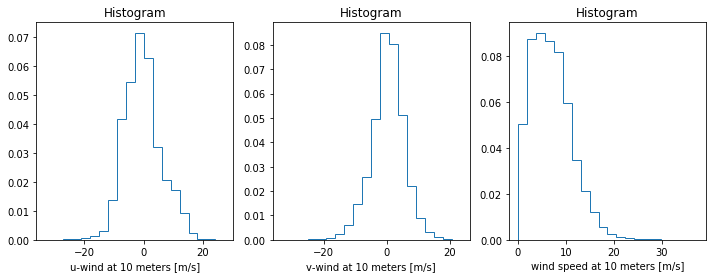

In [14]:
fig, axes = plt.subplots(ncols=3,figsize=[12,4])
ds_ccmp.uwnd.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
ds_ccmp.vwnd.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')
ds_ccmp.wind_speed.plot.hist(bins=20,ax=axes[2],density = True,histtype='step')

### Selecting data and interpolation onto different grids

Data is given all all sorts of different grids.  It is often useful to put things on the same grid so that they can be compared and subsetted to the region of interest.

Let's read in a SST dataset:

<xarray.Dataset>
Dimensions:           (lat: 901, lon: 1800, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2011-11-01T12:00:00
  * lat               (lat) float32 -90.0 -89.8 -89.6 -89.4 ... 89.6 89.8 90.0
  * lon               (lon) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      CMC 0.2 deg global sea surface temperature an...
    summary:                    Applies the method of statistical interpolati...
    references:                 Brasnett B. 2008. The impact of satellite ret...
    institution:                CMC
    history:                    Processed through sfc.thin_sst, sfc.sstobs, i...
    comment:                    WARNING Some applications are un

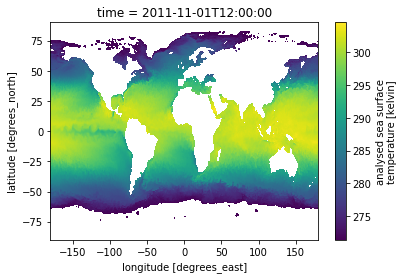

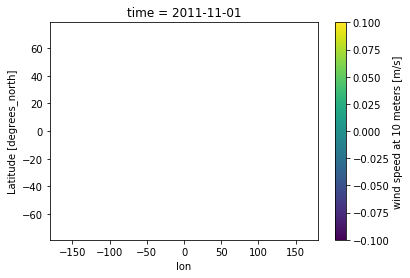

In [24]:
ds_ccmp_masked = ds_ccmp.where(ds_sst_new.mask>0)
ds_ccmp_masked.wind_speed[0,:,:].plot()

## There is no land mask in CCMP data
### to add a land mask lets use use .where and ds_ccmp.nobs to set data over land to NaN.  
### nobs is the number of observations not a land mask, but it is a quick way to see how to use .where
### The xarray function .where(cond,other) the argument other is a value that is set when cond=False


In [ ]:
ds_ccmp_ocn = ds_ccmp.where(ds_ccmp.nobs>0,np.nan)
p = ds_ccmp_ocn.wind_speed.plot(x='lon', y='lat', col='time', transform=ccrs.PlateCarree(),
                  subplot_kws={'projection': ccrs.Orthographic(-80, 35)})
for ax in p.axes.flat:
    ax.coastlines()
    ax.stock_img();


There are different options when you interpolate.  First, let's just do a linear interpolation using [.interp()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp)

`Dataset.interp(coords=None, method='linear', assume_sorted=False, kwargs={}, **coords_kwargs))`



In [ ]:
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')

In [ ]:
dif = ds_collocated_nearest.sst-ds_usv.TEMP_CTD_MEAN
print('mean difference = ',dif.mean().data)
print('STD = ',dif.std().data)

# xarray can do more!

* concatentaion
* open network located files with openDAP
* import and export Pandas DataFrames
* .nc dump to 
* groupby_bins
* resampling and reduction

For more details, read this blog post: http://continuum.io/blog/xray-dask


In [ ]:
#ds_collocated_nearest.to_netcdf('./data/new file.nc')

## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences

For analyzing GCM output:

- [xgcm](https://github.com/xgcm/xgcm) by Ryan Abernathey
- [oogcm](https://github.com/lesommer/oocgcm) by Julien Le Sommer
- [MPAS xarray](https://github.com/pwolfram/mpas_xarray) by Phil Wolfram
- [marc_analysis](https://github.com/darothen/marc_analysis) by Daniel Rothenberg

Other tools:

- [windspharm](https://github.com/ajdawson/windspharm): wind spherical harmonics by Andrew Dawson
- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray
